## Task 1: Extract Insights from Data

In [59]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [60]:
data_name = Path('Oppositional_thinking_analysis_dataset')
data_path = Path('data_ota') / data_name.with_suffix(".json")
assert data_path.exists, "File doesn't exist!"

In [61]:
"""
read file
----------
use data frame in pandas to observe the structure of data
total 4000 texts:
+ unique id
+ unique text
+ 2 categories: conspiracy, critical, represent the 2 sides of oppsitional thinking
+ annotations: sub-features, contain 5 categories
+ spacy_tokens: tokenized text
"""
with open(data_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.json_normalize(data)
df.shape

(4000, 5)

### 1. General view of categories

In [62]:
"""
add 2 new columns in data frame, for further visualizaiton:
text length
unique words
"""
df['text_length'] = df['text'].apply(len)
df['unique_words'] = df['text'].apply(lambda x: len(set(x.split())))
display(df.head())

,id,text,category,annotations,spacy_tokens,text_length,unique_words
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48
2,13116,2021 : They wanted to know your vaccination st...,CRITICAL,"[{'span_text': 'someone who died suddenly', 'c...",WyIyMDIxIiwgIjoiLCAiVGhleSIsICJ3YW50ZWQiLCAidG...,198,28
3,11439,Anthony Fauci once again defended brutal Chine...,CRITICAL,"[{'span_text': 'brutal Chinese lockdowns', 'ca...",WyJBbnRob255IiwgIkZhdWNpIiwgIm9uY2UiLCAiYWdhaW...,326,47
4,98,Proof has emerged showing that death from Wuha...,CRITICAL,[{'span_text': 'death from Wuhan coronavirus (...,WyJQcm9vZiIsICJoYXMiLCAiZW1lcmdlZCIsICJzaG93aW...,698,105


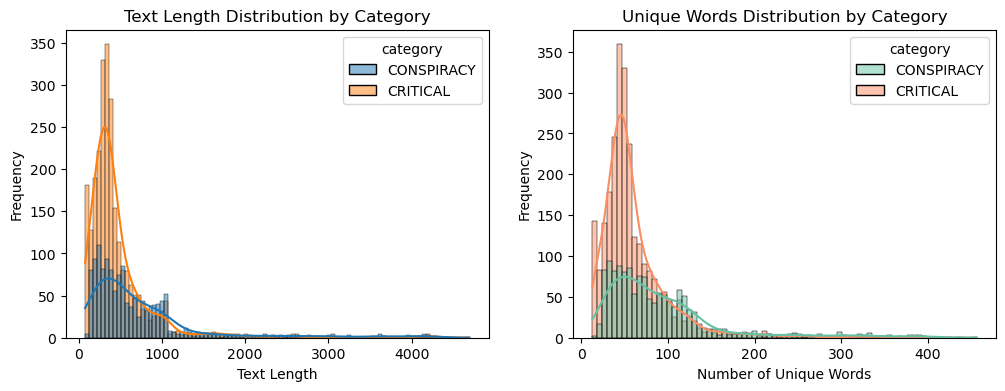

In [63]:
"""
plot the distribution of 'text length' and 'unique words'
"""
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.histplot(data=df, x='text_length', hue='category', kde=True)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.histplot(data=df, x='unique_words', hue='category', kde=True, palette='Set2')
plt.title('Unique Words Distribution by Category')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')

plt.show()

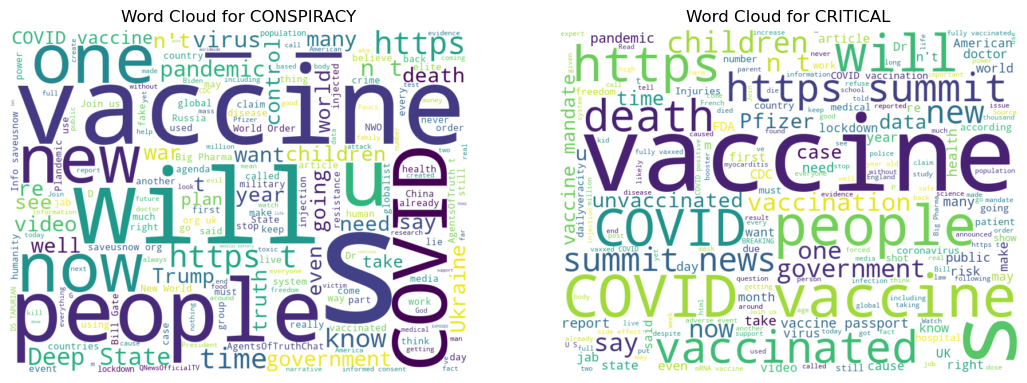

In [64]:
"""
use Word Cloud to visualize each category
"""
plt.figure(figsize=(13, 8))
for category, i in zip(df['category'].unique(), range(2)):
    text = " ".join(df[df['category'] == category]['text'])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.subplot(1, 2, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
plt.show()

### 2. Look into the annotations

In [65]:
"""
extract information of annotations and tokens
----------
+ span text
+ 5 annotation categories:  CAMPAIGNER, AGENT, NEGATIVE_EFFECT, VICTIM, FACILITATOR, OBJECTIVE, X
"""
annotations_expanded = df.explode('annotations')[['id', 'annotations']]
annotations_df = pd.json_normalize(annotations_expanded['annotations'])
annotations_df['id'] = annotations_expanded['id'].values
display(annotations_df.head())

category_counts = annotations_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
display(category_counts.transpose())

,span_text,category,annotator,start_char,end_char,start_spacy_token,end_spacy_token,id
0,Australian Senator Malcolm Roberts,CAMPAIGNER,gold_label,16,50,3,7,5206
1,the first politician,CAMPAIGNER,gold_label,135,155,24,27,5206
2,I ’m deeply concerned that the push to vaccina...,NEGATIVE_EFFECT,gold_label,2,135,1,22,1387
3,to vaccinate these children,OBJECTIVE,gold_label,38,65,8,12,1387
4,these children,VICTIM,gold_label,51,65,10,12,1387


,0,1,2,3,4,5,6
category,CAMPAIGNER,AGENT,NEGATIVE_EFFECT,VICTIM,FACILITATOR,OBJECTIVE,X
count,5096,5082,4387,3517,2763,1602,206


In [66]:
"""
merge annotation categories into df
"""
df = df.merge(annotations_df.groupby('id')['category'].apply(list).reset_index(), on='id', how='left', suffixes=('', '_annotations'))
df.head(2)

,id,text,category,annotations,spacy_tokens,text_length,unique_words,category_annotations
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37,"[CAMPAIGNER, CAMPAIGNER]"
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48,"[NEGATIVE_EFFECT, OBJECTIVE, VICTIM, CAMPAIGNE..."


## Task 2: Pre-processing

In [67]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import time
import base64
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly
import plotly.express as px

In [68]:
"""
use nltk for normalization
"""
def download_with_progress(resource):
    print(f"Downloading {resource}...")
    for _ in tqdm(range(100), desc=f"Downloading {resource}", unit="B", unit_scale=True, ncols=100):
        time.sleep(0.01)
    nltk.download(resource)

download_with_progress('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer() # initialize nltk stemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siyux\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
def decode_tokens(tokens):
    """
    decode spaCy tokens from base64
    add to column -> decoded_tokens
    """
    decoded_bytes = base64.b64decode(tokens)
    decoded_str = decoded_bytes.decode('utf-8')
    return json.loads(decoded_str)

def preprocess_stpw(tokens):
    """
    normalization: remove punctuation and stop words
    add to column -> process_stpw
    """
    tokens = [token.lower() for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

def preprocess_stpw_stem(tokens):
    """
    normalization: stop words removal and stemming
    add to column -> process_stpw_stem
    """
    tokens = [stemmer.stem(token.lower()) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(tokens)

df['decoded_tokens'] = df['spacy_tokens'].apply(decode_tokens)
df['process_stpw_stem'] = df['decoded_tokens'].apply(preprocess_stpw_stem)
df['process_stpw'] = df['decoded_tokens'].apply(preprocess_stpw)

In [70]:
df.head(2)

,id,text,category,annotations,spacy_tokens,text_length,unique_words,category_annotations,decoded_tokens,process_stpw_stem,process_stpw
0,5206,THIS IS MASSIVE Australian Senator Malcolm Rob...,CONSPIRACY,[{'span_text': 'Australian Senator Malcolm Rob...,WyJUSElTIiwgIklTIiwgIk1BU1NJVkUiLCAiQXVzdHJhbG...,218,37,"[CAMPAIGNER, CAMPAIGNER]","[THIS, IS, MASSIVE, Australian, Senator, Malco...",thi is massiv australian senat malcolm robert ...,this is massive australian senator malcolm rob...
1,1387,“ I ’m deeply concerned that the push to vacci...,CRITICAL,[{'span_text': 'I ’m deeply concerned that the...,WyJcdTIwMWMiLCAiSSIsICJcdTIwMTltIiwgImRlZXBseS...,294,48,"[NEGATIVE_EFFECT, OBJECTIVE, VICTIM, CAMPAIGNE...","[“, I, ’m, deeply, concerned, that, the, push,...",i deepli concern push vaccin children noth dys...,i deeply concerned push vaccinate children not...


#### *** Visualization after Preprocessing

In [137]:
# vectorization using tf-idf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['process_stpw'])
# dimision reduction using tsne
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
df_tsne['category'] = df['category']
df_tsne = df_tsne[df_tsne['category'].isin(['CONSPIRACY', 'CRITICAL'])]

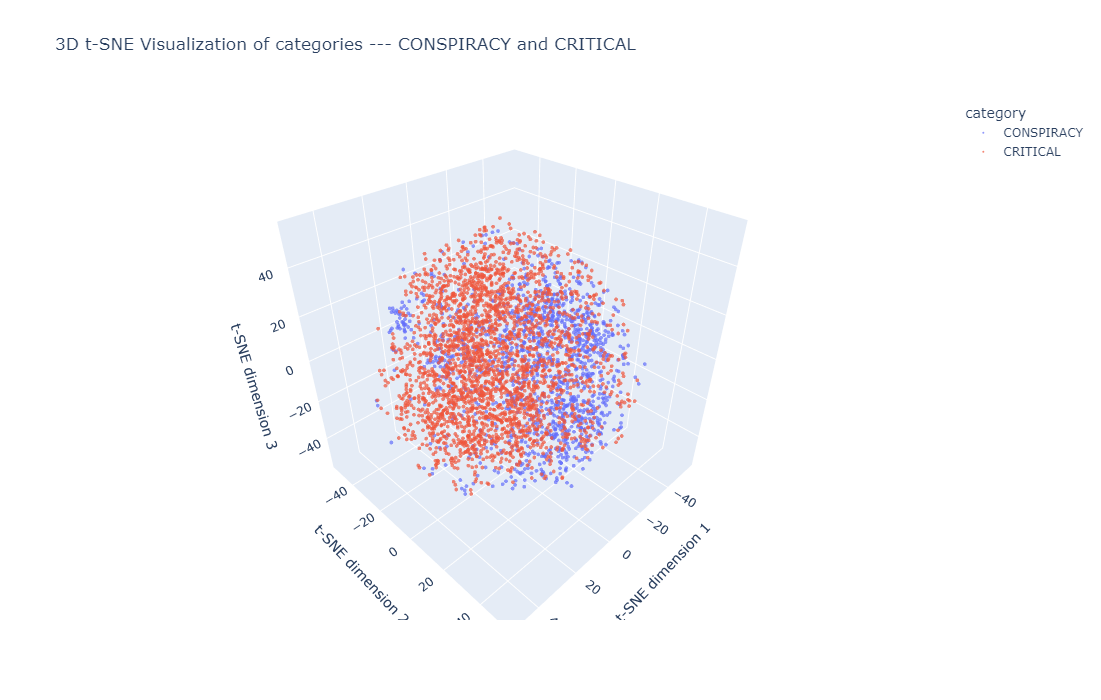

In [138]:
fig = px.scatter_3d(df_tsne, x='x', y='y', z='z', color='category', 
                    title='3D t-SNE Visualization of categories --- CONSPIRACY and CRITICAL',
                    labels={'x': 't-SNE dimension 1', 'y': 't-SNE dimension 2', 'z': 't-SNE dimension 3'},
                    opacity=0.7,
                    width=800, height=700)
fig.update_traces(marker=dict(size=2))
fig.show()

In [139]:
# vectorization using tf-idf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['process_stpw'])
# dimision reduction using tsne
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())
# flatten the annotation categories
df_expanded = df.explode('category_annotations')
df_expanded = df_expanded.reset_index(drop=True)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
df_tsne['category_annotations'] = df_expanded['category_annotations']

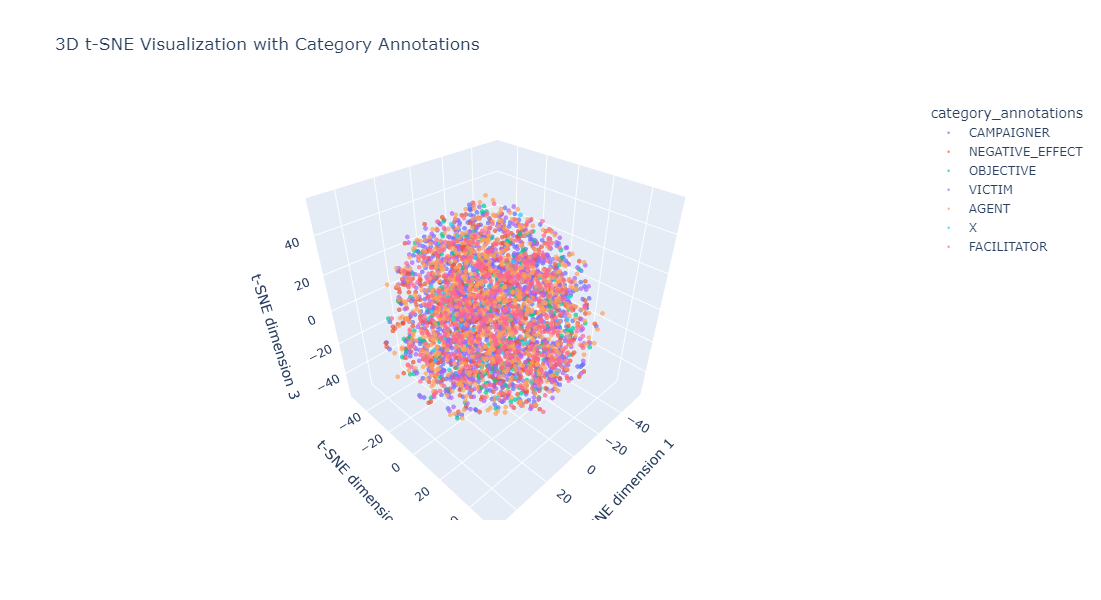

In [142]:
fig = px.scatter_3d(df_tsne, x='x', y='y', z='z', color='category_annotations', 
                    title='3D t-SNE Visualization with Category Annotations',
                    labels={'x': 't-SNE dimension 1', 'y': 't-SNE dimension 2', 'z': 't-SNE dimension 3'},
                    opacity=0.7,
                    width=800, height=600)

fig.update_traces(marker=dict(size=2.5))
fig.show()

## Task 3: Text classification

In [50]:
# dependencies for naive bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack

In [51]:
# dependencies for feed forward neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

### Sub-task 1
* Split data into train and test sets. Use 20% of the data as the test set. Make sure to under or
over-sample in case of imbalance in classes.
* Train a naïve Bayes model on the training part and test it, using the test set.
    * Compare the impact of different vectorization models (e.g., count vectorizer, TF-IDF,
    and …) on the final performance of your naïve Bayes model.
    * Compare the impact of different pre-processing pipelines (e.g., with and without stop
    words, stemming, and …) on the final performance of your naïve Bayes model.
    * Perform error analysis on the model’s prediction. In other words, analyze errors that
    have been made by the model and describe why your model couldn’t work well in
    case of these errors.

In [109]:
class ModelComparison:
    """
    Compare between: different classifiers, normalization methods, vectorization methods
    ----------
    parameters:
    + X: text data only normalized with stpw removal or also with stemming, can be set from outside
    + y: categories, need to be preprocessed in FNN
    + evluation: dict, use for visualizing comparison
    + history: training dynamics along epochs
    + model: classifier type
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test, self.y_pred = None, None, None, None, None
        self.history = None
        self.evaluation = {
            'model': [],
            'vectorizer': [],
            'accuracy': []
        }
        self.accuracy = None
        self.model = None

    def set_X(self, X):
        """
        either stpw or stpw&stem
        """
        self.X = X
        
    def set_vectorizer(self, vectorizer):
        """
        Vectorize the text or text&annotations into feature vectors.
        """
        if vectorizer == 'bow':
            return CountVectorizer()
        elif vectorizer == 'tfidf':
            return TfidfVectorizer()

    def set_model(self, model):
        """
        set classifier type from outside, take care the format of y
        """
        self.model = model
        if model == 'fnn':
            self.y = to_categorical(pd.factorize(df['category'])[0])
            
    def predict(self, vectorizer='bow', model='nb'):
        """
        training entry, data splitting
        """
        V = self.set_vectorizer(vectorizer)
        X_vectorized = V.fit_transform(self.X)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_vectorized, self.y, test_size=0.2, random_state=42)
        
        if self.model == 'nb':
            M = MultinomialNB()
            M.fit(self.X_train, self.y_train)
            self.y_pred = M.predict(self.X_test)
            self.evaluation_nb()
            
        elif model == 'fnn':
            input_dim = self.X_train.shape[1]
            output_dim = len(np.unique(self.y))
            self.fit_fnn(input_dim, output_dim)
            self.evaluation_fnn()
        self.update_eval(vectorizer, model)
    
    def fit_fnn(self, input_dim, output_dim):
        """
        3-layer fnn; 
        optimizer: adam; 
        regularization: dropout;
        loss function: cross entropy;
        evaluation score: f1, accuracy
        best epoch arount 6th
        ----------
        | layer | size | activation |
        |-------|------|------------|
        | 1 fully connected | 128 | ReLU |
        | 2 fully connected | 64 | ReLU |
        | 3 output | 2 | SoftMax |
        """
        model = Sequential()
        model.add(Dense(128, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))
        # train
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', ModelComparison.f1_score])
        # store metrics
        self.history = model.fit(self.X_train.toarray(), self.y_train, epochs=7, batch_size=32, verbose=1)
        self.y_pred = np.argmax(model.predict(self.X_test.toarray()), axis=1)
        self.accuracy = max(self.history.history['accuracy'])
    
    def evaluation_nb(self):
        """
        print and plot report for nb model
        """
        accuracy = accuracy_score(self.y_test, self.y_pred)
        self.accuracy = accuracy
        report = classification_report(self.y_test, self.y_pred, output_dict=True)
        confusion = confusion_matrix(self.y_test, self.y_pred)

        report_df = pd.DataFrame(report).transpose().iloc[:2]
        confusion = confusion[:2, :2]
        print(f"Accuracy: {accuracy:.4f}\n")
        print("Classification Report:\n", report_df)

        plt.figure(figsize=(6, 2.5))
        plt.subplot(1,2,1)
        sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
        plt.title('Condusion Matix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        plt.subplot(1, 2, 2)
        report_df.drop(['support'], axis=1, inplace=True)
        report_df.plot(kind='bar', ax=plt.gca())
        plt.title('Scores')
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.xticks(rotation=0)
        plt.legend(loc='lower right')
        
        plt.tight_layout()
        plt.show()
        
    def evaluation_fnn(self):
        """
        plot  learned accuracy, loss, f1
        """
        plt.figure(figsize=(5, 3))
        metrics = ['accuracy', 'loss', 'f1_score']
        colors = ['purple', 'gray', 'orange']
        labels = ['Accuracy', 'Loss', 'F1 Score']
        
        for metric, color, label in zip(metrics, colors, labels):
            plt.plot(self.history.history[metric], color=color, label=label)
            plt.fill_between(range(len(self.history.history[metric])), 
                             self.history.history[metric], color=color, alpha=0.1)
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.title('Metrics over Epochs')
        plt.legend()
        plt.show()
        
    def update_eval(self, vectorizer, model):
        self.evaluation['model'].append(model)
        self.evaluation['vectorizer'].append(vectorizer)
        self.evaluation['accuracy'].append(self.accuracy)
        
    @staticmethod
    def f1_score(y_true, y_pred):
        """
        for f1 score in fnn
        """
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        precision = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)) / (tf.reduce_sum(tf.cast(y_pred, tf.float32)) + tf.keras.backend.epsilon())
        recall = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32)) / (tf.reduce_sum(tf.cast(y_true, tf.float32)) + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

In [110]:
# initialize MC (only once, later set other parameters)
MC = ModelComparison(df['process_stpw'], df['category'])
MC.set_model('nb')

Accuracy: 0.8612

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.770115  0.797619  0.783626    252.0
CRITICAL     0.905380  0.890511  0.897884    548.0


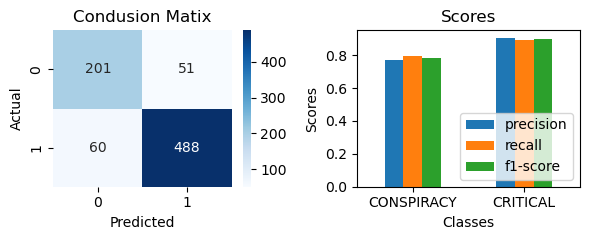

In [111]:
"""
| Nr. | preprocessing | vectorizer | model |
|  01 |  stop words   |    BoW     |  NB   |
"""
MC.predict()

Accuracy: 0.8187

Classification Report:
             precision   recall  f1-score  support
CONSPIRACY   0.981982  0.43254  0.600551    252.0
CRITICAL     0.792453  0.99635  0.882781    548.0


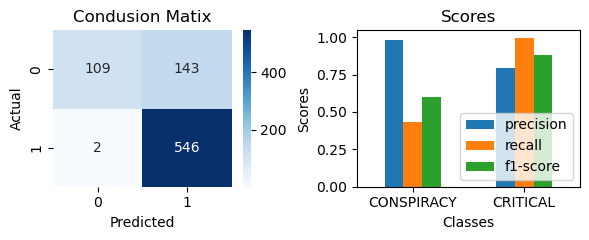

In [112]:
"""
| Nr. | preprocessing | vectorizer | model |
|  02 |  stop words   |    TFI-DF  |  NB   |
"""
MC.predict('tfidf', 'nb')

Accuracy: 0.8638

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.773946  0.801587  0.787524    252.0
CRITICAL     0.907236  0.892336  0.899724    548.0


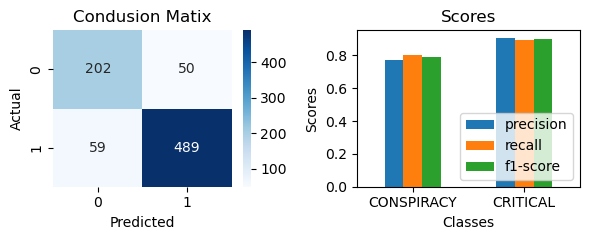

In [113]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  04 |  stop words & stemming  |    BoW     |  NB   |
"""
MC.set_X(df['process_stpw_stem'])
MC.predict('bow', 'nb')

Accuracy: 0.8275

Classification Report:
             precision    recall  f1-score  support
CONSPIRACY   0.959677  0.472222  0.632979    252.0
CRITICAL     0.803254  0.990876  0.887255    548.0


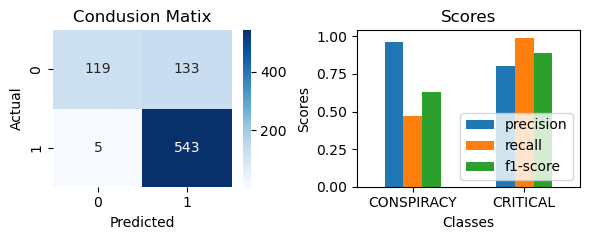

In [114]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  04 |  stop words & stemming  |    TFI-DF  |  NB   |
"""
MC.predict('tfidf', 'nb')

### Sub-task 2
* Train a feed-forward neural network model and report its performance (F1 score) on test data.
    * Again, compare the impact of different vectorization approaches on the final
    performance of your model.
    * Again, Compare the impact of different pre-processing pipelines (e.g., with and
    without stop words, stemming, and …) on the final performance of your model.
    * Perform error analysis on the model’s prediction.

C:\Users\siyux\.conda\envs\mydata\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7320 - f1_score: 0.8055 - loss: 0.5481
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9420 - f1_score: 0.9547 - loss: 0.1811
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9819 - f1_score: 0.9861 - loss: 0.0641
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9932 - f1_score: 0.9944 - loss: 0.0295
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9982 - f1_score: 0.9987 - loss: 0.0162
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9963 - f1_score: 0.9971 - loss: 0.0129
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9988 - f1_score: 0.9991 - loss: 0.0060
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


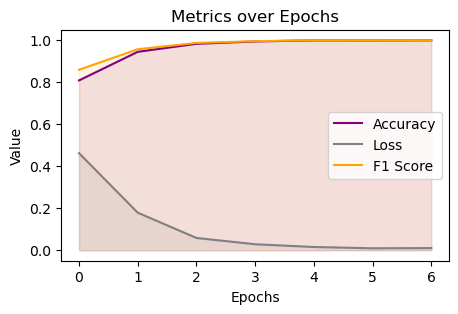

In [115]:
"""
| Nr. | preprocessing | vectorizer | model |
|  05 |  stop words   |    BoW     |  FNN  |
"""
MC.set_model('fnn')
MC.set_X(df['process_stpw'])
MC.predict('bow', 'fnn')

C:\Users\siyux\.conda\envs\mydata\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6668 - f1_score: 0.7826 - loss: 0.6111
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9372 - f1_score: 0.9514 - loss: 0.1741
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9836 - f1_score: 0.9867 - loss: 0.0542
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9958 - f1_score: 0.9965 - loss: 0.0193
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9987 - f1_score: 0.9990 - loss: 0.0070
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9983 - f1_score: 0.9985 - loss: 0.0048
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9993 - f1_score: 0.9995 - loss: 0.0045
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


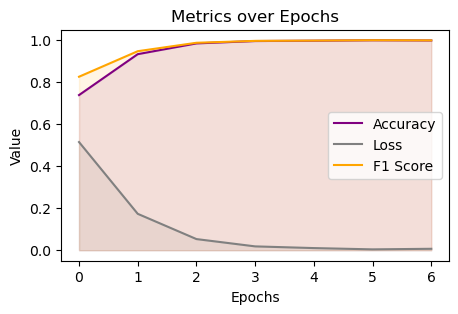

In [118]:
"""
| Nr. | preprocessing | vectorizer | model |
|  06 |  stop words   |    TFI-DF  |  FNN  |
"""
MC.predict('tfidf', 'fnn')

Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7438 - f1_score: 0.8229 - loss: 0.5547
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9347 - f1_score: 0.9497 - loss: 0.1944
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9807 - f1_score: 0.9846 - loss: 0.0767
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9913 - f1_score: 0.9930 - loss: 0.0385
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9961 - f1_score: 0.9969 - loss: 0.0213
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9977 - f1_score: 0.9981 - loss: 0.0149
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9980 - f1_score: 0.9984 - loss: 0.0092
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


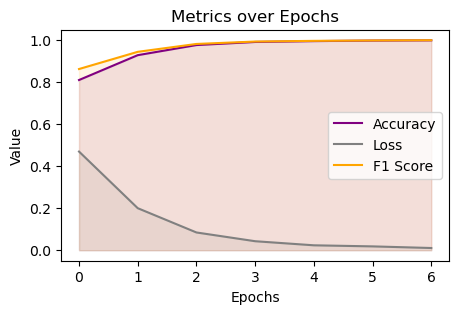

In [119]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  07 |  stop words & stemming  |    BoW     |  FNN  |
"""
MC.set_X(df['process_stpw_stem'])
MC.predict('bow', 'fnn')

Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6520 - f1_score: 0.7736 - loss: 0.6150
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9226 - f1_score: 0.9386 - loss: 0.2168
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9737 - f1_score: 0.9786 - loss: 0.0853
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9915 - f1_score: 0.9931 - loss: 0.0326
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9983 - f1_score: 0.9986 - loss: 0.0138
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9978 - f1_score: 0.9984 - loss: 0.0072
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9992 - f1_score: 0.9994 - loss: 0.0046
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


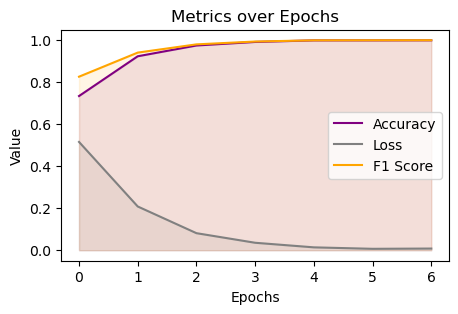

In [120]:
"""
| Nr. | preprocessing           | vectorizer | model |
|  08 |  stop words & stemming  |    TFI-DF  |  FNN  |
"""
MC.predict('tfidf', 'fnn')

### Sub-task 3
* Compare the performance of your naïve Bayes model with the achieved results from the feed-
forward model. What can you conclude from the differences between the performance of the
two models? \
***ANSWER***
    * Using counter vectorizer/BoW improve the accuracy significantly for naive bayes classifier, while not necessary for FNN, since FNN is apparently reaching close-to-optimal result. 

,0,1,2,3,4,5,6,7
model,nb,nb,nb,nb,fnn,fnn,fnn,fnn
vectorizer,bow,tfidf,bow,tfidf,bow,tfidf,bow,tfidf
accuracy,0.86125,0.81875,0.86375,0.8275,0.997813,0.999375,0.998125,0.998125
process,stpw,stpw,stpw&stem,stpw&stem,stpw,stpw,stpw&stem,stpw&stem


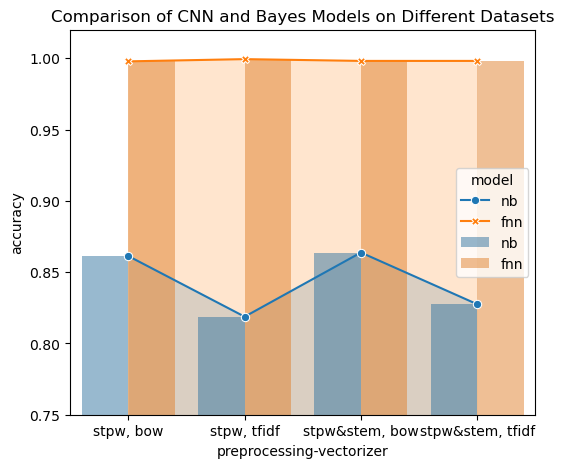

In [122]:
"""
synthetic comparison
"""
def plot_compar(data):
    """
    add normalization, plot info stored in MC.evaluation
    """
    df = pd.DataFrame(data)
    plt.figure(figsize=(6,5))
    df['process'] = ['stpw','stpw','stpw&stem','stpw&stem','stpw','stpw','stpw&stem','stpw&stem']
    display(df.transpose())
    df['pv'] = df['process'] + ', ' + df['vectorizer']
    sns.lineplot(x='pv', y='accuracy', hue='model', style='model', data=df, markers=True, dashes=False)
    models = df['model'].unique()
    for model in models:
        subset = df[df['model'] == model]
        plt.fill_between(subset['pv'], subset['accuracy'], alpha=0.2)
    sns.barplot(x='pv', y='accuracy', hue='model', data=df, alpha=0.5)

    plt.ylim(0.75, 1.02)
    plt.title('Comparison of CNN and Bayes Models on Different Datasets')
    plt.xlabel('preprocessing-vectorizer')
    plt.ylabel('accuracy')
    plt.show()

plot_compar(MC.evaluation)

## Task 4: PMI based word similarity

In [126]:
import random

In [127]:
def cooccurrence_matrix(tokenized_texts, window_size=2):
    """
    window_size: the range of context words to consider, fixed -> 2
    cooccurrence matrix: the co-occurrence counts of each word with its context words
    """
    cooccu = defaultdict(Counter)
    for text in tokenized_texts:
        for idx, word in enumerate(text):
            start = max(0, idx - window_size)
            end = min(len(text), idx + window_size + 1)
            for idx2 in range(start, end):
                if idx2 != idx:
                    cooccu[word][text[idx2]] += 1
    return cooccu

def pmi_matrix(cooccu, total_words, min_count=2):
    """
    total_words: total number of words in corpus
    min_count: minimum co-occurrence count threshold, best at 2 (avoiding None)
    PMI matrix: PMI values of each word with its context words
    """
    pmi_matrix = defaultdict(dict)
    word_counts = Counter()
    for word, neighbors in cooccu.items():
        word_counts[word] += sum(neighbors.values())
    
    total_count = sum(word_counts.values())
    for word, neighbors in cooccu.items():
        for neighbor, count in neighbors.items():
            if count >= min_count:
                p_w = word_counts[word] / total_count
                p_n = word_counts[neighbor] / total_count
                p_wn = count / total_count
                pmi = np.log2(p_wn / (p_w * p_n))
                if pmi > 0:
                    pmi_matrix[word][neighbor] = pmi
    return pmi_matrix

def most_similar_words(pmi_mat, word, n=5):
    if word in pmi_mat:
        similar_words = sorted(pmi_mat[word].items(), key=lambda x: x[1], reverse=True)[:n]
        return [w for w, _ in similar_words]
    else:
        return [None] * n     # if the target word is not in the PMI matrix, return n None values

In [128]:
df['tokenized_text'] = df['process_stpw_stem'].apply(lambda x: x.split())
cooccu_mat = cooccurrence_matrix(df['tokenized_text'].tolist())

In [129]:
total_words = sum([len(text) for text in df['tokenized_text']])
pmi_mat = pmi_matrix(cooccu_mat, total_words)

In [130]:
random_words = random.sample(list(pmi_mat.keys()), 10)
similar_words = {word: most_similar_words(pmi_mat, word) for word in random_words}

In [131]:
report_df = pd.DataFrame.from_dict(similar_words, orient='index', columns=[f'Similar Word {i+1}' for i in range(5)])
report_df.index.name = 'Random Word'
report_df.reset_index(inplace=True)
report_df

,Random Word,Similar Word 1,Similar Word 2,Similar Word 3,Similar Word 4,Similar Word 5
0,cave,coronavirus,bat,None,None,None
1,lin,replytolinwood,fightback,sayin,wood,drew
2,till,wait,due,3,None,None
3,dhabi,abu,unvaccin,None,None,None
4,pharmakeon,pharmakeia,None,None,None,None
5,earth,inherit,flat,mine,planet,reach
6,fifteen,rock,fulli,world,year,vaccin
7,90,minut,95,day,moderna,jab
8,retail,presenc,sector,None,None,None
9,nathan,wolf,dod,founder,structur,viral
